## Example on how to use the modules on MD_ML 

### Part 1: Preprocessing 

In [2]:
import sys
sys.path.append("/home/stylianos/Desktop/Final_MD_ML/MD_ML/")

from TrajectoryTools import LoadTrajectories, ParseTrajectory, down_sample
from ipywidgets.widgets import Box
from ImageTrasformation import xyz2rgb
import ipywidgets 
import nglview as nv
from Createfolders import CreateFolders as cf
import tensorflow as tf

In [4]:
# Load trajectories
trajs = LoadTrajectories().traj_from_dir('/martini/stylianos/ERGF2/data')
trajs

Found 2 trajectories:


{'inactive': <Universe with 5241 atoms>, 'active': <Universe with 5232 atoms>}

In [66]:
inactive = trajs['inactive']
active = trajs['active']

In [63]:
view1 = nv.show_mdanalysis(inactive)
view2 = nv.show_mdanalysis(active)

In [65]:
Box(children=(view1,view2))

Box(children=(NGLWidget(max_frame=165000, n_components=1), NGLWidget(max_frame=165000, n_components=1)))

In [11]:
# Allign trajectories to the first frame on the inactive state. (The first state that initalizes the 'ParseTrajectory' class)
Xi = ParseTrajectory('inactive', inactive.select_atoms('name CA')).allign()
Xa = ParseTrajectory('active', active.select_atoms('name CA')).allign()

In [12]:
# Down-sample trajectories
Xi_downsampled =  down_sample(Xi, 1650)
Xa_downsampled =  down_sample(Xa, 1650)


In [15]:
# Transcribe the trajectories' coordinates to RGB values
Xi_rgb = xyz2rgb(Xi_downsampled)
Xa_rgb = xyz2rgb(Xa_downsampled)

In [16]:
# Paths to save results
savepath = '/home/stylianos/Desktop/test'

active_img_path = '/home/stylianos/Desktop/test/imgs/active'
inactive_img_path = '/home/stylianos/Desktop/test/imgs/inactive'

cf(savepath).create_subfolders() # ['results', 'performance', 'imgs', 'models']

cf(active_img_path).create()
cf(inactive_img_path).create()

In [17]:
# Save images
for i in range(Xi_rgb.shape[0]):
            tf.keras.utils.save_img(f'{inactive_img_path}/inactive_{i}.jpg',Xi_rgb[i])

for i in range(Xa_rgb.shape[0]):
            tf.keras.utils.save_img(f'{active_img_path}/active_{i}.jpg',Xa_rgb[i])

### Part 2: Machine Learning module

In [18]:
from setup import *

In [19]:
# Load data
train_generator, test_generator = load_data(
        directory = f"{savepath}/imgs", 
        height = Xi_rgb.shape[1], 
        lenght = Xi_rgb.shape[2]
        )

Found 2640 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [20]:
# Build and compile model
model = build_and_compile_cnn_model(input_shape = train_generator.image_shape,
                                    n_classes = train_generator.num_classes
)

2023-02-10 18:22:53.804640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-10 18:22:53.804671: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-10 18:22:53.806462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (Conv2D)              (None, 98, 324, 32)       896       
                                                                 
 second (Conv2D)             (None, 96, 322, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 161, 32)      0         
 )                                                               
                                                                 
 third (Conv2D)              (None, 46, 159, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 79, 64)       0         
 2D)                                                             
                                                                 
 fourth (Conv2D)             (None, 21, 77, 64)        3

In [21]:
# Fit model
history = fit_model(model, train_generator, test_generator)

Epoch 1/3
132/132 [==============================] - 129s 963ms/step - loss: 0.2224 - accuracy: 0.8777 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
132/132 [==============================] - 126s 944ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
132/132 [==============================] - 130s 974ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


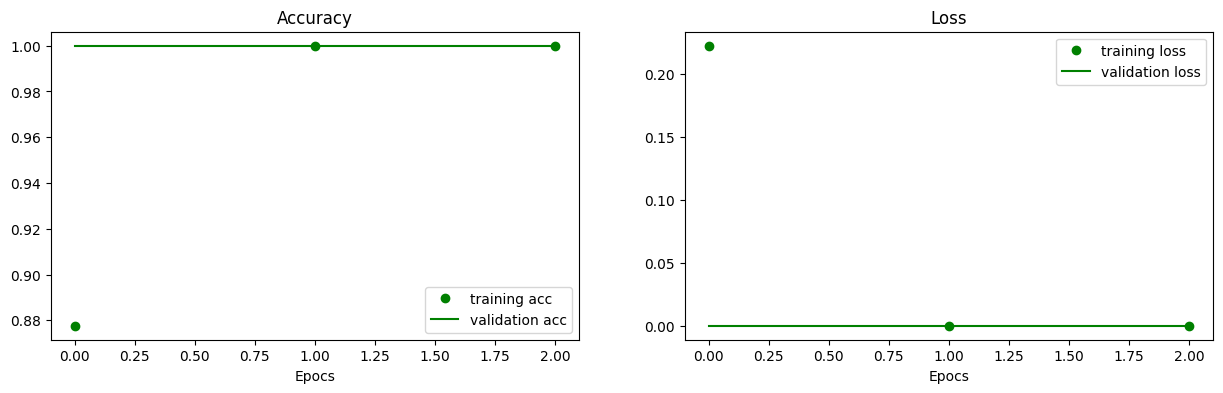

In [22]:
# Plot performance
get_performance(history= history,
                path_to_save = None, 
                save = False)

In [23]:
# Get predictions
y_pred =  np.argmax(model.predict(test_generator), axis = 1)  

33/33 [==============================] - 5s 150ms/step


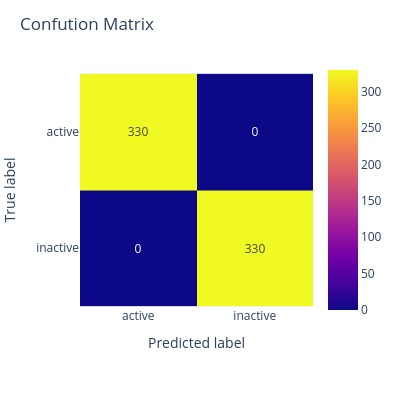

In [24]:
# Plot cm
plot_confusion_matrix( 
    generator=test_generator,
    y_pred = y_pred,
    path_to_save= f'{savepath}/results/confusion_matrix.jpg',
    )
tf.keras.utils.load_img(f'{savepath}/results/confusion_matrix.jpg')

### Part 3: Mapping module. Find the important residues for each class

In [25]:
# Import libraries
import Mapper
import Vision2 as vis2
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Get a radom image from each state
img_a = f'{active_img_path}/active_0.jpg'
img_i = f'{inactive_img_path}/inactive_0.jpg'

In [27]:
# 'NotImplimentedYet' from setup  use this instead
def decode(img_path):
    img = np.array(tf.keras.preprocessing.image.load_img(
        path = img_path,
        grayscale=False, 
        color_mode="rgb"))
    return img / 255

In [28]:
# Salienct maps
sal_map_a = vis2.Saliencymap(model,decode(img_a)).gradient_saliency_map()
sal_map_i = vis2.Saliencymap(model,decode(img_i)).gradient_saliency_map()

# Class activation maps
gradcam_a = vis2.Cam(model).grad_cam(decode(img_a), 1)
gradcam_i = vis2.Cam(model).grad_cam(decode(img_i), 1)

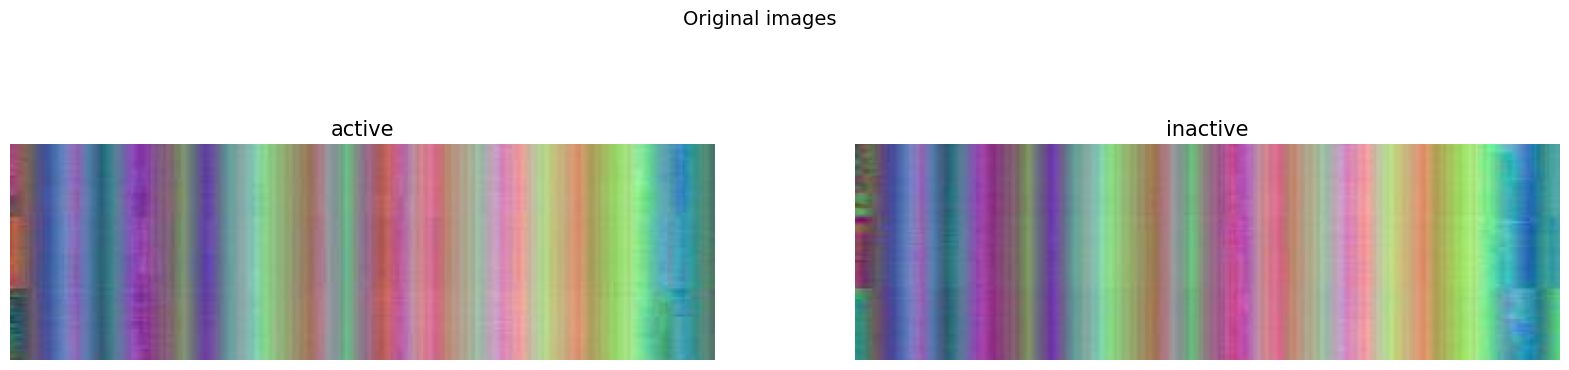

In [29]:

plt.figure(figsize=(20, 5))
plt.suptitle('Original images', fontsize = 14)

ax = plt.subplot(1, 2, 1)
plt.imshow(decode(img_a))
plt.axis('off')
plt.title('active', fontsize = 15)

ax = plt.subplot(1, 2, 2)
plt.title('inactive', fontsize = 15)
plt.imshow(decode(img_i))
plt.axis('off')
plt.show()

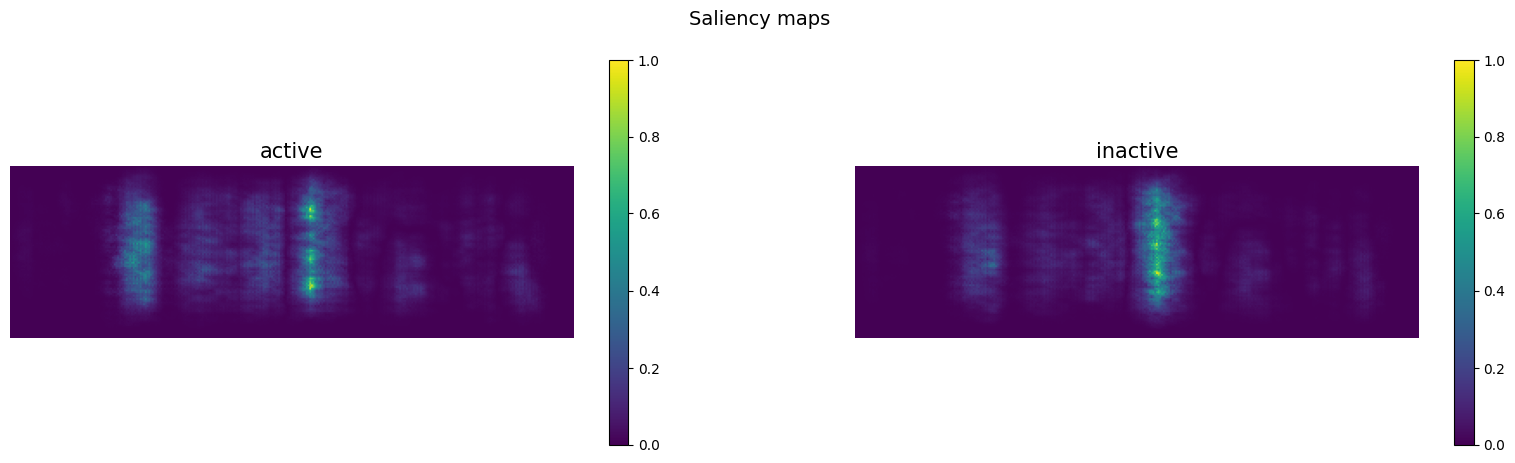

In [36]:
plt.figure(figsize=(20, 5))
plt.suptitle('Saliency maps', fontsize = 14)

ax = plt.subplot(1, 2, 1)
plt.imshow(sal_map_a)
plt.colorbar()
plt.axis('off')
plt.title('active', fontsize = 15)

ax = plt.subplot(1, 2, 2)
plt.title('inactive', fontsize = 15)
plt.imshow(sal_map_i)
plt.colorbar()
plt.axis('off')
plt.show()

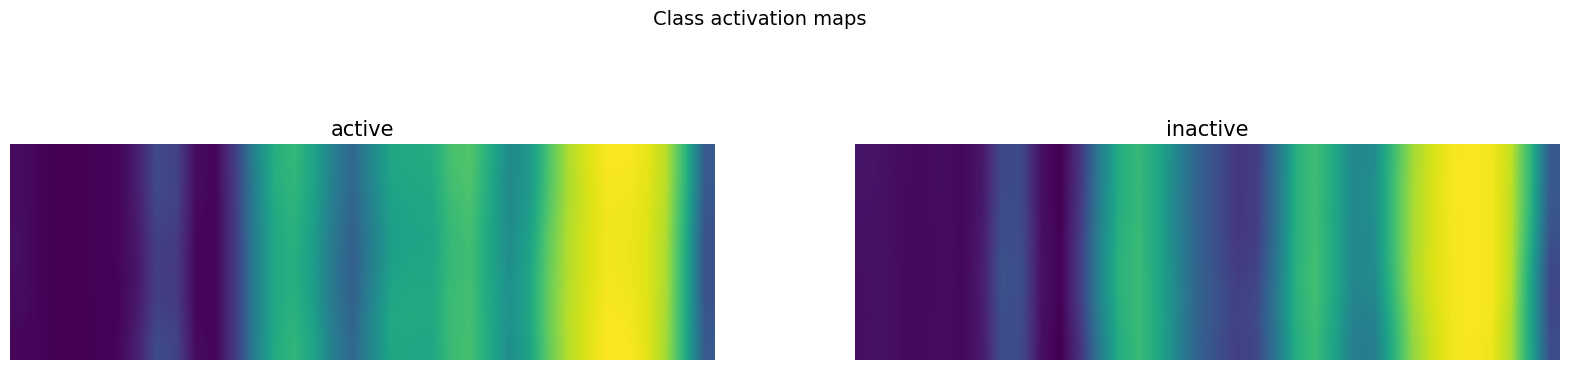

In [31]:
plt.figure(figsize=(20, 5))
plt.suptitle('Class activation maps', fontsize = 14)

ax = plt.subplot(1, 2, 1)
plt.imshow(gradcam_a)
plt.axis('off')
plt.title('active', fontsize = 15)

ax = plt.subplot(1, 2, 2)
plt.title('inactive', fontsize = 15)
plt.imshow(gradcam_i)
plt.axis('off')
plt.show()

In [37]:
# Update the tempfactors of the residues
for residue, r_value in zip(active.select_atoms('protein').residues,np.mean(sal_map_a, axis =0)):
    residue.atoms.tempfactors = r_value

for residue, r_value in zip(inactive.select_atoms('protein').residues,np.mean(sal_map_i, axis =0)):
    residue.atoms.tempfactors = r_value

In [67]:
view1.update_representation(color_scheme='bfactor')
view2.update_representation(color_scheme='bfactor')

In [68]:
Box(children=(view1,view2))

Box(children=(NGLWidget(max_frame=165000, n_components=1), NGLWidget(max_frame=165000, n_components=1)))

In [40]:
# Take the mean along the first axis (100, 326) -> (326,)
imprt_res_a = np.mean(sal_map_a, axis = 0)
imprt_res_i = np.mean(sal_map_i, axis = 0)

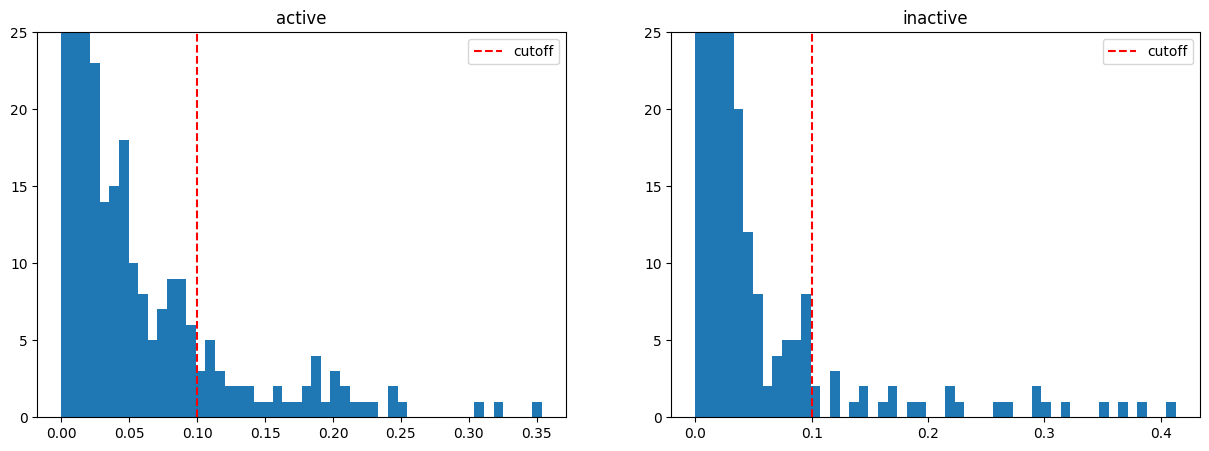

In [71]:
# Frequecy plots 
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.hist(imprt_res_a, bins = 50)
plt.title('active')
plt.ylim(0,25)
plt.axvline(0.10, color = 'red',  linestyle = '--', label = 'cutoff')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.hist(imprt_res_i, bins = 50)
plt.title('inactive')
plt.ylim(0,25)
plt.axvline(0.10, color = 'red',  linestyle = '--', label = 'cutoff')
plt.legend()
plt.show()

In [80]:
# Find important residues
mask_a = np.where(imprt_res_a > 0.10)[0]
mask_i = np.where(imprt_res_i > 0.10)[0]

In [57]:
inactive.select_atoms("protein").write(f"{savepath}/results/inactive.pdb")
active.select_atoms("protein").write(f"{savepath}/results/active.pdb")

In [81]:
print(f'Important residues for active state: {Mapper.find_res_index(active, mask_a)}')
print(f'Important residues for inactive state: {Mapper.find_res_index(inactive, mask_i)}')


Important residues for active state: 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 836, 838, 839, 840, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879
Important residues for inactive state: 767, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879


~End~